In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
# input files/dirs
MUTATION_DENSITY_GENIC_REGIONS = "../results/mutation_density_genic_regions"

## Passenger mutation density by genic region

In [3]:
files = os.listdir(MUTATION_DENSITY_GENIC_REGIONS)
files = [f for f in files if f.endswith(".tsv") and "promoter" not in f]
print(files)

mut_genic_df = pd.DataFrame()
for f in files:
	df = pd.read_csv(f"{MUTATION_DENSITY_GENIC_REGIONS}/{f}", sep="\t")
	df["cancer_type"] = f.split(".")[0]
	mut_genic_df = pd.concat([mut_genic_df, df])
mut_genic_df.reset_index(drop=True, inplace=True)
print(mut_genic_df.shape)

mut_genic_df["passenger_density_log"] = np.log10(mut_genic_df["passenger_density"] + 1)
mut_genic_df["adj_passenger_density_log"] = np.log10(mut_genic_df["adj_passenger_density"] + 1)
print(mut_genic_df.shape)
# 0-5, 5-10, >=10 mutations/Mb are defined as low, medium and high TMB groups respectively
mut_genic_df["TMB"] = mut_genic_df["total_mutations"] * 1e6 / (3.2 * 1e9) # mutations/Mb for 3.2 Gb genome size
mut_genic_df["TMB_group"] = pd.cut(mut_genic_df["TMB"], bins=[0, 5, 10, np.inf], labels=["Low (0-5/Mb)", "Medium (5-10/Mb)", "High (>=10/Mb)"])

['CNS-Oligo.tsv', 'Kidney-ChRCC.tsv', 'Prost-AdenoCA.tsv', 'Kidney-RCC.tsv', 'Stomach-AdenoCA.tsv', 'CNS-Medullo.tsv', 'Thy-AdenoCA.tsv', 'Myeloid-MPN.tsv', 'Bone-Leiomyo.tsv', 'Lymph-BNHL.tsv', 'Myeloid-AML.tsv', 'Lung-AdenoCA.tsv', 'CNS-GBM.tsv', 'Head-SCC.tsv', 'Breast-AdenoCa.tsv', 'Ovary-AdenoCA.tsv', 'CNS-PiloAstro.tsv', 'Cervix-SCC.tsv', 'Liver-HCC.tsv', 'Bone-Osteosarc.tsv', 'Biliary-AdenoCA.tsv', 'Skin-Melanoma.tsv', 'Lung-SCC.tsv', 'Lymph-CLL.tsv', 'Panc-Endocrine.tsv', 'Bladder-TCC.tsv', 'Panc-AdenoCA.tsv', 'ColoRect-AdenoCA.tsv', 'Breast-LobularCa.tsv', 'Eso-AdenoCa.tsv', 'Uterus-AdenoCA.tsv']
(197712, 8)
(197712, 10)


In [4]:
mut_genic_df_mean = mut_genic_df.groupby(["genic_region", "has_driver"]).agg({
    "adj_passenger_density": "mean"
}).reset_index()

In [5]:
# get number of data points with non-zero adjusted passenger density for each genic region and driver status
mut_genic_df_nonzero = mut_genic_df[mut_genic_df["adj_passenger_density"] > 0]
mut_genic_df_counts = mut_genic_df_nonzero.groupby(["genic_region", "has_driver"]).size().reset_index(name="counts")
mut_genic_df_counts = mut_genic_df_counts.merge(mut_genic_df_mean, on=["genic_region", "has_driver"])

['intronic', 'exonic', 'ncRNA', 'UTR3', 'UTR5', 'upstream', 'downstream']


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2696/1367094626.py:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

exonic_True vs. exonic_False: t-test independent samples with Benjamini-Hochberg correction, P_val:1.975e-04 t=-3.723e+00
intronic_True vs. intronic_False: t-test independent samples with Benjamini-Hochberg correction, P_val:1.097e-20 t=-9.335e+00
ncRNA_True vs. ncRNA_False: t-test independent samples with Benjamini-Hochberg correction, P_val:1.452e-02 t=-2.444e+00


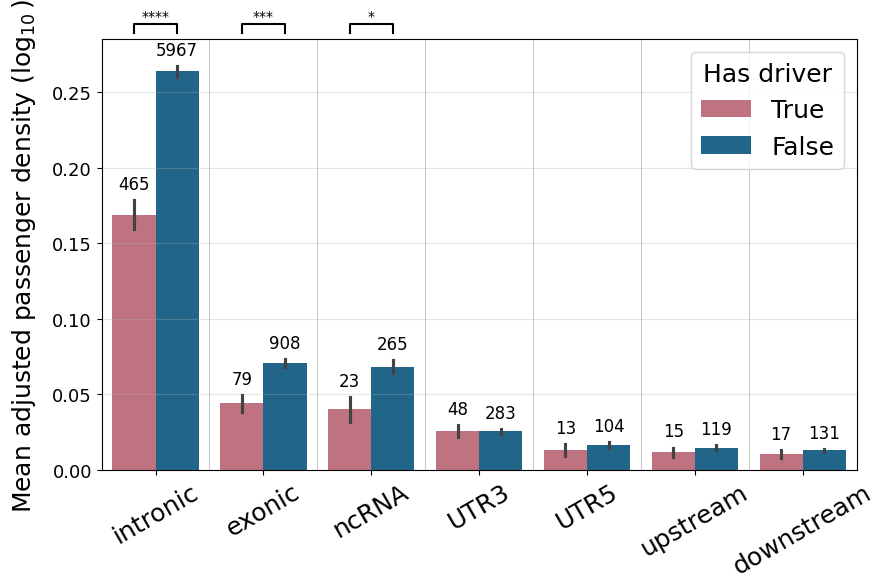

In [6]:
plt.figure(figsize=(9, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

# sort genic region by mean passenger density
mean_values = mut_genic_df.groupby(["genic_region"])["adj_passenger_density_log"].mean().reset_index()
mean_values.sort_values(by="adj_passenger_density_log", ascending=False, inplace=True)
mean_values_order = mean_values["genic_region"].tolist()
mean_values_order.remove("-")
mean_values_order.remove("splicing")
print(mean_values_order)

ax = sns.barplot(
    x="genic_region",
	y="adj_passenger_density_log",
	hue="has_driver",
	data=mut_genic_df,
    order=mean_values_order,
    hue_order=[True, False],
    palette=cmap,
    errorbar='se',
)

# annotate bars with counts of non-zero data points
for region in mean_values_order:
    for has_driver in [True, False]:
        # get count from precomputed DataFrame
        count_values = mut_genic_df_counts[
            (mut_genic_df_counts["genic_region"] == region) & 
            (mut_genic_df_counts["has_driver"] == has_driver)
        ]["counts"].values

        if len(count_values) > 0:
            count = count_values[0]
            subset = mut_genic_df[
                (mut_genic_df["genic_region"] == region) & 
                (mut_genic_df["has_driver"] == has_driver)
            ]["adj_passenger_density_log"]
            mean_val = subset.mean()
            error_val = subset.sem()
            x_pos = mean_values_order.index(region) + (-0.2 if has_driver else 0.2)
            ax.annotate(
                f'{count}',
                xy=(x_pos, mean_val + error_val),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=12,
                color='black'
            )

# add grid lines
ax.grid(axis='y', alpha=0.3)
for i in range(len(mean_values_order) - 1):
	ax.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# add statistical significance annotations
box_pairs = []
for region in mean_values_order:
    region_data = mut_genic_df[mut_genic_df["genic_region"] == region]
    if len(region_data["has_driver"].unique().tolist()) == 2:
        box_pairs.append(((region, True), (region, False)))

annotator = Annotator(
    ax, 
    data=mut_genic_df,
    x="genic_region",
    y="adj_passenger_density_log", 
    hue="has_driver",
    order=mean_values_order,
    hue_order=[True, False],
    pairs=box_pairs,
)
annotator.configure(test='t-test_ind', text_format='star', loc='outside', hide_non_significant=True, color='black')
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xlabel("")
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=13)
plt.ylabel(r"Mean adjusted passenger density ($\log_{10}$)", fontsize=18, labelpad=10)
plt.ylim(0, 0.285)
plt.legend(title="Has driver", fontsize=18, title_fontsize=18)
plt.tight_layout()
plt.savefig("../results/PCAWG/mutation_density_genic_regions.png", dpi=300)

In [7]:
mut_genic_df_TMB_mean = mut_genic_df.groupby(["genic_region", "has_driver", "TMB_group"]).agg({
    "adj_passenger_density": "mean"
}).reset_index()

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2696/1363747356.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mut_genic_df_TMB_mean = mut_genic_df.groupby(["genic_region", "has_driver", "TMB_group"]).agg({


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2696/3277920587.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


['Low (0-5/Mb)', 'Medium (5-10/Mb)', 'High (>=10/Mb)']


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2696/3277920587.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=11)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2696/3277920587.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2696/3277920587.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=11)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2696/3277920587.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2

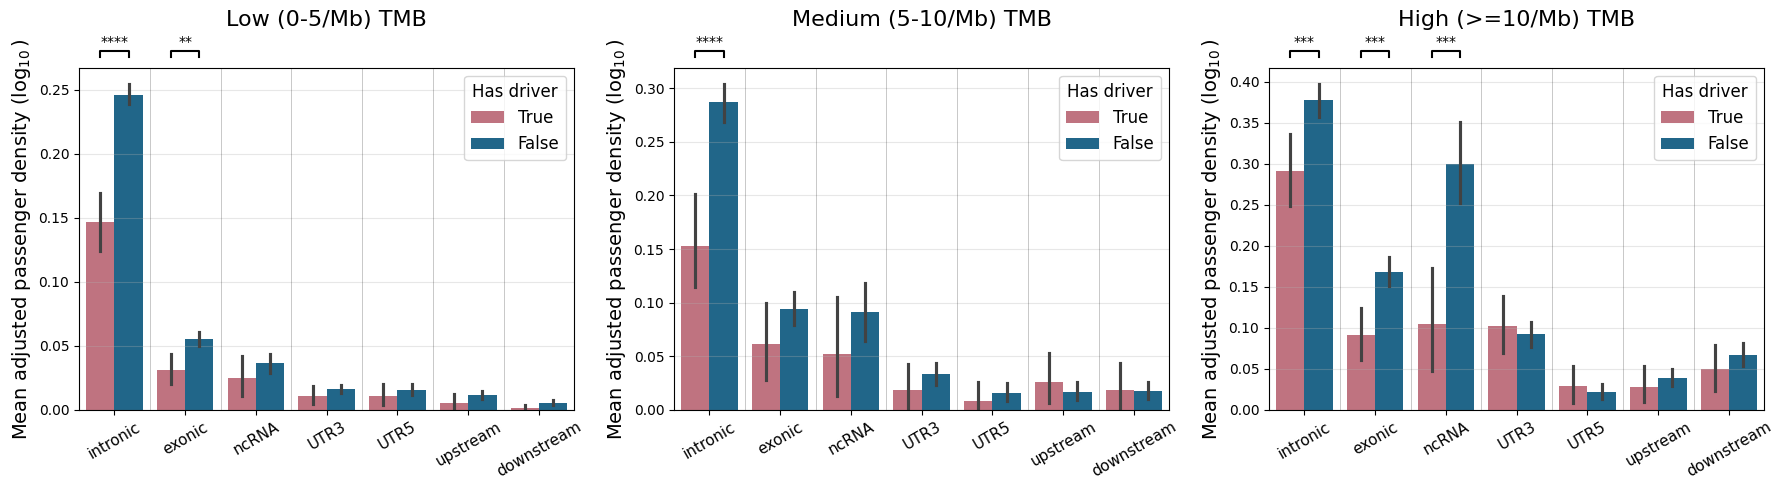

In [ ]:
tmb_groups = mut_genic_df["TMB_group"].cat.categories.tolist()
print(tmb_groups)

# Set up 3x1 subplot grid (for 3 groups)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

# sort genic region by mean passenger density
mean_values = mut_genic_df.groupby(["genic_region"])["adj_passenger_density_log"].mean().reset_index()
mean_values.sort_values(by="adj_passenger_density_log", ascending=False, inplace=True)
mean_values_order = mean_values["genic_region"].tolist()
mean_values_order = [r for r in mean_values_order if r not in ["-", "splicing"]]

for idx, group in enumerate(tmb_groups):
    ax = axes[idx]
    group_data = mut_genic_df[mut_genic_df["TMB_group"] == group]

    sns.barplot(
        x="genic_region",
        y="adj_passenger_density_log",
        hue="has_driver",
        data=group_data,
        order=mean_values_order,
        hue_order=[True, False],
        palette=cmap,
        ax=ax
    )

    # Add grid lines
    ax.grid(axis='y', alpha=0.3)
    for i in range(len(mean_values_order) - 1):
        ax.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

    # Add statistical significance annotations
    box_pairs = []
    for region in mean_values_order:
        region_data = group_data[group_data["genic_region"] == region]
        if len(region_data["has_driver"].unique().tolist()) == 2:
            box_pairs.append(((region, True), (region, False)))

    if box_pairs:  # only annotate if comparisons exist
        annotator = Annotator(
            ax,
            data=group_data,
            x="genic_region",
            y="adj_passenger_density_log",
            hue="has_driver",
            order=mean_values_order,
            hue_order=[True, False],
            pairs=box_pairs,
        )
        annotator.configure(
            test='t-test_ind',
            text_format='star',
            loc='outside',
            hide_non_significant=True,
            color='black',
            comparisons_correction="fdr_bh",
            verbose=0
        )
        annotator.apply_test().annotate()

    ax.set_title(f"{group} TMB", fontsize=16, pad=30)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=11)
    ax.set_ylabel(r"Mean adjusted passenger density ($\log_{10}$)", fontsize=14)
    ax.legend(title="Has driver", fontsize=12, title_fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig("../results/PCAWG/mutation_density_genic_regions_TMB_stratified.png", dpi=300)

# source data
mut_genic_df[["genic_region", "has_driver", "adj_passenger_density", "TMB_group"]].to_csv("../plot_data/passenger_density/mutation_density_genic_regions.tsv", sep="\t", index=False)